# Selection Bias and Mediators

**Chapter 7, Section 3**

This notebook covers why controlling for post-treatment variables (mediators) is dangerous and leads to selection bias.

## Table of Contents
1. [Intuition](#intuition) - Mediators block causal paths
2. [Formal Treatment](#formal) - Selection bias in potential outcomes
3. [Numeric Demonstration](#numeric) - Email campaign mediators
4. [Implementation](#implementation) - Detecting post-treatment bias
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Mediator Problem

A **mediator** is a variable on the causal path from treatment to outcome:

```
T → M → Y
```

If we control for M, we **block the causal path** and capture only the "direct" effect (if any exists).

**The email campaign example**:
```
Email → Opened → Payments
Email → Agreement → Payments
```

If we control for "opened" or "agreement":
- We're asking: "What's the effect of email, holding constant whether they opened/agreed?"
- But email CAUSES opening/agreement!
- We're blocking the very mechanism through which email works

★ Insight ─────────────────────────────────────
- Controlling for mediators answers a DIFFERENT question
- Total effect: T → (all paths) → Y
- "Direct" effect: T → Y (not via mediator) - often nonsensical
- Selection bias: comparing incomparable groups
─────────────────────────────────────────────────

In [2]:
# Load email campaign data
email = load_facure_data("collections_email.csv")

print(f"Data: {len(email)} customers")
print(f"\nMediator 'opened': email was opened")
print(f"Mediator 'agreement': signed payment agreement")
print(f"\nKey insight: These are POST-TREATMENT variables!")

# Show that mediators depend on treatment
print(f"\nP(opened | email=1) = {email.loc[email['email']==1, 'opened'].mean():.1%}")
print(f"P(opened | email=0) = {email.loc[email['email']==0, 'opened'].mean():.1%}")
print(f"→ Can't open an email you didn't receive!")

Data: 5000 customers

Mediator 'opened': email was opened
Mediator 'agreement': signed payment agreement

Key insight: These are POST-TREATMENT variables!

P(opened | email=1) = 55.7%
P(opened | email=0) = 0.0%
→ Can't open an email you didn't receive!


---

## Formal Treatment

### Selection Bias from Conditioning on Post-Treatment Variables

Let $M$ be a mediator: $T \to M \to Y$

The **total effect** is:
$$\tau_{total} = E[Y_1] - E[Y_0]$$

If we condition on $M = m$:
$$\tau_{M=m} = E[Y | T=1, M=m] - E[Y | T=0, M=m]$$

**Problem**: $\{i: T_i=1, M_i=m\}$ and $\{i: T_i=0, M_i=m\}$ are NOT comparable groups!

### Potential Outcomes Argument

Let $M(t)$ denote the potential mediator value under treatment $t$.

When we condition on $M = m$:
- In treatment group: Those with $M(1) = m$
- In control group: Those with $M(0) = m$

These are **different types of people**!

**Example**: Among email recipients, "opened = 1" selects engaged customers. Among non-recipients, "opened = 0" includes everyone. We're comparing apples to oranges.

$$E[Y_0 | T=1, M=m] \neq E[Y_0 | T=0, M=m]$$

In [3]:
# CORRECT: Total effect without mediators
model_correct = smf.ols('payments ~ email + credit_limit + risk_score', data=email).fit()

# WRONG: Controlling for mediators
model_bad = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=email).fit()

print("EFFECT OF EMAIL ON PAYMENTS")
print("=" * 55)
print(f"\nCorrect (no mediators):     {model_correct.params['email']:.2f} (SE: {model_correct.bse['email']:.2f})")
print(f"WRONG (with mediators):     {model_bad.params['email']:.2f} (SE: {model_bad.bse['email']:.2f})")
print(f"\n→ Effect nearly DISAPPEARS when controlling for mediators!")
print(f"→ This is because email works THROUGH opening/agreement")

EFFECT OF EMAIL ON PAYMENTS

Correct (no mediators):     4.43 (SE: 2.13)
WRONG (with mediators):     -1.61 (SE: 2.72)

→ Effect nearly DISAPPEARS when controlling for mediators!
→ This is because email works THROUGH opening/agreement


---

## Numeric Demonstration

### Understanding Why the Effect Disappears

In [4]:
# The mediators are on the causal path
print("Mediator analysis:")
print(f"\nEffect of email on 'opened':")
model_email_opened = smf.ols('opened ~ email', data=email).fit()
print(f"  β = {model_email_opened.params['email']:.3f}")

print(f"\nEffect of 'opened' on payments (controlling for treatment):")
model_opened_payments = smf.ols('payments ~ opened + email', data=email).fit()
print(f"  β = {model_opened_payments.params['opened']:.2f}")

# Mediation path: email → opened → payments
indirect_effect = model_email_opened.params['email'] * model_opened_payments.params['opened']
print(f"\nIndirect effect (email → opened → payments): {indirect_effect:.2f}")
print(f"Total effect (correct model): {model_correct.params['email']:.2f}")

Mediator analysis:

Effect of email on 'opened':
  β = 0.557

Effect of 'opened' on payments (controlling for treatment):
  β = 12.47

Indirect effect (email → opened → payments): 6.95
Total effect (correct model): 4.43


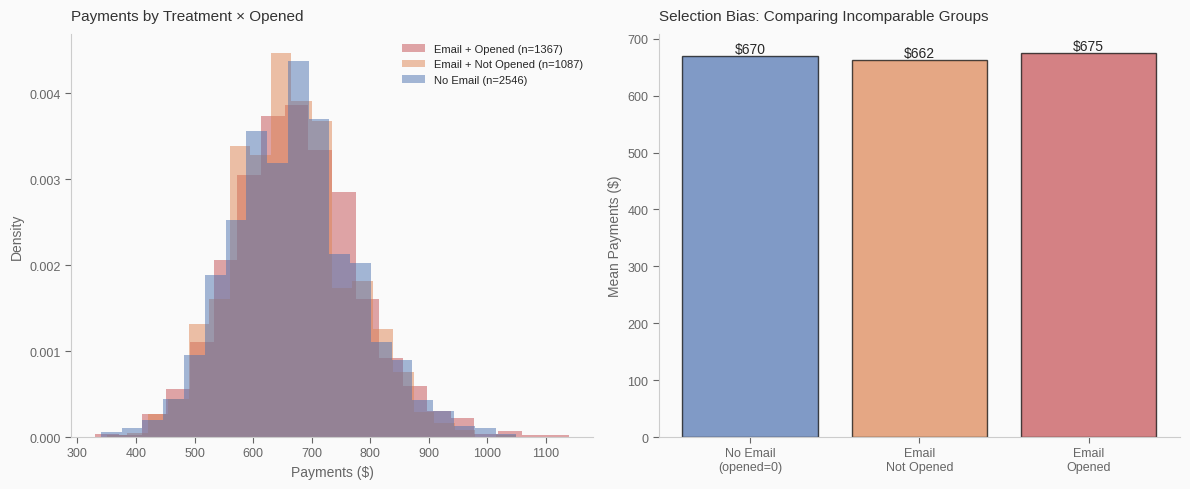


Wrong comparison: Email+Opened vs No Email (opened=0)
  These groups are NOT comparable on unobservables!


In [5]:
# Visualize the selection bias problem
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: Distribution of payments by treatment and mediator
ax = axes[0]

# Create subgroups
groups = [
    (1, 1.0, 'Email + Opened', COLORS['red']),
    (1, 0.0, 'Email + Not Opened', COLORS['orange']),
    (0, 0.0, 'No Email', COLORS['blue']),
]

for email_val, opened_val, label, color in groups:
    mask = (email['email'] == email_val) & (email['opened'] == opened_val)
    subset = email.loc[mask, 'payments']
    if len(subset) > 0:
        ax.hist(subset, bins=20, alpha=0.5, color=color, label=f'{label} (n={len(subset)})', density=True)

set_tufte_title(ax, "Payments by Treatment × Opened")
set_tufte_labels(ax, "Payments ($)", "Density")
ax.legend(frameon=False, fontsize=8)

# Right: Show the selection problem
ax = axes[1]

# Mean payments by group
summary = email.groupby(['email', 'opened'])['payments'].agg(['mean', 'count']).reset_index()
summary.columns = ['email', 'opened', 'mean_payments', 'n']

x_pos = [0, 1, 2]
labels = ['No Email\n(opened=0)', 'Email\nNot Opened', 'Email\nOpened']
means = [
    summary.loc[(summary['email']==0) & (summary['opened']==0), 'mean_payments'].values[0],
    summary.loc[(summary['email']==1) & (summary['opened']==0), 'mean_payments'].values[0] if len(summary.loc[(summary['email']==1) & (summary['opened']==0)]) > 0 else np.nan,
    summary.loc[(summary['email']==1) & (summary['opened']==1), 'mean_payments'].values[0],
]
colors = [COLORS['blue'], COLORS['orange'], COLORS['red']]

bars = ax.bar(x_pos, means, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

# Add values on bars
for bar, mean in zip(bars, means):
    if not np.isnan(mean):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'${mean:.0f}', ha='center', fontsize=10)

set_tufte_title(ax, "Selection Bias: Comparing Incomparable Groups")
set_tufte_labels(ax, "", "Mean Payments ($)")

plt.tight_layout()
plt.show()

print(f"\nWrong comparison: Email+Opened vs No Email (opened=0)")
print(f"  These groups are NOT comparable on unobservables!")

In [6]:
# Show the "principal stratum" problem
# Among email recipients, "opened" selects engaged customers

# Compare characteristics between openers and non-openers (among email recipients)
email_recipients = email[email['email'] == 1]

print("Among email RECIPIENTS:")
print(f"\nMean credit_limit:")
print(f"  Opened=1: ${email_recipients.loc[email_recipients['opened']==1, 'credit_limit'].mean():.0f}")
print(f"  Opened=0: ${email_recipients.loc[email_recipients['opened']==0, 'credit_limit'].mean():.0f}")

print(f"\nMean risk_score:")
print(f"  Opened=1: {email_recipients.loc[email_recipients['opened']==1, 'risk_score'].mean():.3f}")
print(f"  Opened=0: {email_recipients.loc[email_recipients['opened']==0, 'risk_score'].mean():.3f}")

print(f"\n→ Openers have different characteristics than non-openers!")
print(f"→ Conditioning on 'opened' creates selection on unobservables")

Among email RECIPIENTS:

Mean credit_limit:
  Opened=1: $1182
  Opened=0: $1172

Mean risk_score:
  Opened=1: 0.478
  Opened=0: 0.479

→ Openers have different characteristics than non-openers!
→ Conditioning on 'opened' creates selection on unobservables


### The DAG Perspective

```
       credit_limit
           ↓
Email → Opened → Payments
   ↘            ↗
    Agreement →
```

- **Total effect**: All paths from Email to Payments
- **Controlling for Opened**: Blocks Email → Opened → Payments path
- **What remains**: Only "direct" effect (if any) - likely minimal

---

## Implementation

### Detecting Post-Treatment Variables

In [7]:
def check_post_treatment(data, treatment, candidate):
    """
    Check if a candidate variable appears to be post-treatment.
    
    Heuristics:
    1. Treatment strongly predicts candidate
    2. Candidate has structural zeros in control group
    
    Parameters
    ----------
    data : pd.DataFrame
    treatment, candidate : str
        Column names.
        
    Returns
    -------
    dict with assessment
    """
    # Check 1: Does treatment predict candidate?
    model = smf.ols(f'{candidate} ~ {treatment}', data=data).fit()
    r2 = model.rsquared
    
    # Check 2: Structural zeros in control?
    control_vals = data.loc[data[treatment] == 0, candidate]
    treated_vals = data.loc[data[treatment] == 1, candidate]
    
    control_zeros = (control_vals == 0).mean()
    treated_zeros = (treated_vals == 0).mean()
    
    # Assessment
    is_post_treatment = (
        (r2 > 0.1) or  # Treatment explains >10% of variance
        (control_zeros > 0.95)  # Structural zeros in control
    )
    
    return {
        'candidate': candidate,
        'R2_treatment': r2,
        'control_zeros_pct': control_zeros,
        'treated_zeros_pct': treated_zeros,
        'likely_post_treatment': is_post_treatment,
        'warning': 'DO NOT CONTROL FOR THIS VARIABLE' if is_post_treatment else 'Probably safe'
    }

# Check mediators
for var in ['opened', 'agreement', 'credit_limit']:
    result = check_post_treatment(email, 'email', var)
    print(f"\n{var}:")
    print(f"  R² with treatment: {result['R2_treatment']:.3f}")
    print(f"  Control zeros: {result['control_zeros_pct']:.1%}")
    print(f"  → {result['warning']}")


opened:
  R² with treatment: 0.390
  Control zeros: 100.0%
  → DO NOT CONTROL FOR THIS VARIABLE

agreement:
  R² with treatment: 0.199
  Control zeros: 100.0%
  → DO NOT CONTROL FOR THIS VARIABLE

credit_limit:
  R² with treatment: 0.001
  Control zeros: 0.0%
  → Probably safe


In [8]:
# Summary table: correct vs incorrect specifications
specifications = [
    ('payments ~ email', 'No controls'),
    ('payments ~ email + credit_limit + risk_score', 'Pre-treatment only (CORRECT)'),
    ('payments ~ email + opened', 'With mediator (WRONG)'),
    ('payments ~ email + agreement', 'With mediator (WRONG)'),
    ('payments ~ email + credit_limit + risk_score + opened + agreement', 'All variables (WRONG)'),
]

results = []
for formula, desc in specifications:
    model = smf.ols(formula, data=email).fit()
    results.append({
        'Specification': desc,
        'Email Effect': model.params['email'],
        'SE': model.bse['email'],
        't-stat': model.tvalues['email'],
        'p-value': model.pvalues['email']
    })

results_df = pd.DataFrame(results)
print("\nComparison of Specifications:")
print(results_df.to_string(index=False))


Comparison of Specifications:
               Specification  Email Effect     SE  t-stat  p-value
                 No controls       -0.6203 2.9415 -0.2109   0.8330
Pre-treatment only (CORRECT)        4.4304 2.1299  2.0801   0.0376
       With mediator (WRONG)       -7.5661 3.7645 -2.0099   0.0445
       With mediator (WRONG)        2.2539 3.2853  0.6861   0.4927
       All variables (WRONG)       -1.6095 2.7237 -0.5909   0.5546


---

## Interview Appendix

### Practice Questions

**Q1: Why is controlling for post-treatment variables dangerous?**

<details>
<summary>Solution</summary>

Post-treatment variables are **affected by treatment**, which causes two problems:

**1. Blocking causal paths (mediators)**:
- If T → M → Y, controlling for M removes the indirect effect
- The "direct effect" may be meaningless or zero
- Example: "What's the effect of college on income, holding constant whether you got a degree?"

**2. Selection bias**:
- Conditioning on M = m selects different subpopulations in T=1 vs T=0
- These groups are not comparable on unobservables
- Violates exchangeability: E[Y₀|T=1, M=m] ≠ E[Y₀|T=0, M=m]

**Rule**: Only control for **pre-treatment** variables that are not affected by the treatment assignment mechanism.

</details>

**Q2: What's the difference between a mediator and a confounder?**

<details>
<summary>Solution</summary>

| Property | Confounder | Mediator |
|----------|------------|----------|
| **DAG position** | Common cause: C → T, C → Y | On causal path: T → M → Y |
| **Timing** | Pre-treatment | Post-treatment |
| **Affected by T?** | No | Yes |
| **Control for it?** | ✅ Yes (removes bias) | ❌ No (blocks effect) |

**Key distinction**: A confounder creates a spurious association that must be removed. A mediator is **part of the causal mechanism** and should NOT be controlled for (for total effect estimation).

**Exception**: Mediation analysis intentionally decomposes total effect into direct + indirect, but this requires special methods (Baron-Kenny, counterfactual mediation).

</details>

**Q3: In an A/B test, the analyst controls for "pages viewed after randomization." What's wrong?**

<details>
<summary>Solution</summary>

**Problem**: "Pages viewed after randomization" is a **post-treatment variable** that is likely affected by treatment.

**Scenario**: Testing a new homepage design
- Treatment: New design vs old design
- Outcome: Conversion (purchase)
- "Control": Pages viewed

**Why it's wrong**:
1. New design might encourage more browsing → pages viewed is a mediator
2. Controlling for pages viewed compares:
   - Treatment users who viewed X pages despite new design
   - Control users who viewed X pages with old design
   - These are NOT comparable groups!

**Result**: The estimated effect is biased—could be underestimated (if new design → more pages → conversion) or overestimated (if selection bias dominates).

**Correct approach**: Only control for pre-randomization variables (user history, demographics, etc.)

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 7.

[^2]: Montgomery, J. M., et al. (2018). How conditioning on post-treatment variables can ruin your experiment.

[^3]: Cross-reference: Mediation analysis in `src/causal_inference/mediation/estimators.py` (Baron-Kenny, NDE/NIE)